In [1]:
import numpy as np
from collections import OrderedDict

In [2]:
def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)

    x_max = np.max(x, axis=1, keepdims=True)
    x_exp = np.exp(x - x_max)
    x_exp_sum = np.sum(x_exp, axis=1, keepdims=True)
    y = x_exp / x_exp_sum

    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        y = y.reshape(1, -1)

    loss = -np.mean(np.log(y[np.arange(y.shape[0]), t] + 1e-6))

    return loss

In [3]:
class Affine:
    def __init__(self, W, b) -> None:
        self.W = W
        self.b = b

        self.x = np.array([])

        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x

        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.x.T, dout)

        dx = np.dot(dout, self.W.T)

        return dx

class Relu:
    def __init__(self) -> None:
        self.mask = None

    def forward(self, x):
        self.mask = x <= 0
        out = x
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dx = dout
        dx[self.mask] = 0

        return dx

class SoftmaxWithLoss:
    def __init__(self) -> None:
        self.y = np.array([])
        self.t = None

    def forward(self, x, t):
        self.y = softmax(x)
        self.t = t
        loss = cross_entropy_error(self.y, self.t)

        return loss

    def backward(self):
        t_onehot = np.zeros_like(self.y)
        t_onehot[np.arange(t_onehot.shape[0]), self.t] = 1
        
        batch_size = self.y.shape[0]
        dx = (self.y - t_onehot) / batch_size

        return dx

class BatchNormal:  # BatchNormal层
    def __init__(self) -> None:
        self.var_sqrt = None  # 用于计算反向传播梯度

    def forward(self, x):
        mean = np.mean(x, axis=0, keepdims=True)
        self.var_sqrt = np.sqrt(np.mean(np.square(x - mean), axis=0, keepdims=True))
        out = (x - mean) / self.var_sqrt

        return out


    def backward(self, dout):
        dx = self.var_sqrt * dout

        return dx

In [ ]:
class TwoLayersNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.1) -> None:
        self.params_key = ['W1', 'b1', 'W2', 'b2']
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNormal1'] = BatchNormal()  # 添加一个BatchNormal层
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastlayer = SoftmaxWithLoss()

    def predict(self, x):
        y = x
        for layer in self.layers.values():
            y = layer.forward(y)

        return y

    def loss(self, x, t):
        y = self.predict(x)
        loss = self.lastlayer.forward(y, t)

        return loss

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        accuracy = np.mean(y == t)

        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = self.lastlayer.backward()
        dx = dout

        reversed_layers = list(self.layers.values())[::-1]
        for layer in reversed_layers:
            dx = layer.backward(dx)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [5]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    download=False,
    transform=transform
)

x_train_list = []
t_train_list = []
for image, label in train_dataset:
    x_train_list.append(image)
    t_train_list.append(label)

x_train = np.array(x_train_list)
x_train = x_train.reshape(x_train.shape[0], -1)
t_train = np.array(t_train_list)

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST(
    root='../data',
    train=False,
    download=False,
    transform=transform
)

x_test_list = []
t_test_list = []
for image, label in test_dataset:
    x_test_list.append(image)
    t_test_list.append(label)

x_test = np.array(x_test_list)
x_test = x_test.reshape(x_test.shape[0], -1)
t_test = np.array(t_test_list)

In [ ]:
np.random.seed(42)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size // batch_size, 1)

weight_init_std_list = [1, 0.01, 0.1]

loss_result = {}
for wis in weight_init_std_list:
    network = TwoLayersNet(784, 100, 10, wis)
    train_loss_list = []
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad = network.gradient(x_batch, t_batch)

        for key in network.params_key:
            network.params[key] -= learning_rate * grad[key]
            
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
    loss_result[wis] = train_loss_list

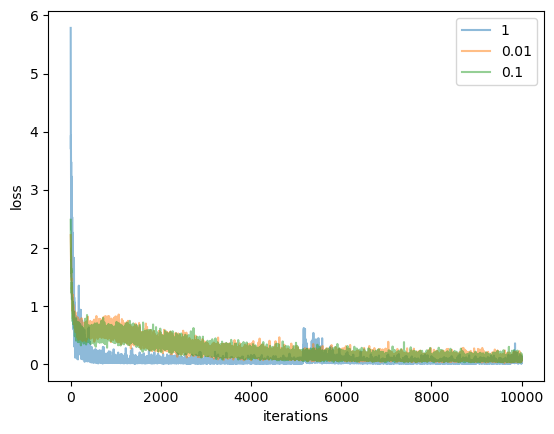

In [7]:
import matplotlib.pyplot as plt

for key, val in loss_result.items():
    plt.plot(val, label=key, alpha=0.5)

plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()